In [1]:
! pip install -q keras

In [2]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
from tqdm import tqdm
import pickle
import scipy.ndimage.interpolation as inter
from scipy.signal import medfilt
from scipy.spatial.distance import cdist

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras import backend as K
import keras
import tensorflow as tf

1. Define configurations

In [3]:
random.seed(1234)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 15 # the number of joints
        self.joint_d = 2 # the dimension of joints
        self.clc_num = 21 # the number of class
        self.feat_d = 105
        self.filters = 64
C = Config()

2. Define data processing functions

In [4]:
# Temple resizing function
def zoom(p,target_l=64,joints_num=25,joints_dim=3):
    l = p.shape[0]
    p_new = np.empty([target_l,joints_num,joints_dim])
    for m in range(joints_num):
        for n in range(joints_dim):
            p[:,m,n] = medfilt(p[:,m,n],3)
            p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
    return p_new



# Calculate JCD feature
def norm_scale(x):
    return (x-np.mean(x))/np.mean(x)

def get_CG(p,C):
    M = []
    iu = np.triu_indices(C.joint_n,1,C.joint_n)
    for f in range(C.frame_l):
        d_m = cdist(p[f],p[f],'euclidean')
        d_m = d_m[iu]
        M.append(d_m)
    M = np.stack(M)
    M = norm_scale(M)
    return M
    
def cutmix_data(X, Y, alpha=1.0):
    '''
    X: Input images or features 
    Y: Corresponding labels
    alpha: Hyperparameter for beta distribution.

    Returns augmented data and labels.
    '''
    batch_size = X.shape[0]
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0

    # Select random indices for mixing
    indices = np.random.permutation(batch_size)
    X1, X2 = X, X[indices]
    Y1, Y2 = Y, Y[indices]

    # Mix data
    bbx1, bby1, bbx2, bby2 = rand_bbox(X.shape[1:], lam)
    X[:, bbx1:bbx2, bby1:bby2, :] = X2[:, bbx1:bbx2, bby1:bby2, :]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (X.shape[1] * X.shape[2]))

    # Mix labels
    Y = lam * Y1 + (1 - lam) * Y2
    return X, Y

def rand_bbox(size, lam):
    '''
    Generate random bounding box for CutMix.
    size: Shape of the input 
    lam: Mixing ratio.
    '''
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # Uniform random center
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def data_generator_with_cutmix(T, C, le, apply_cutmix=False, alpha=1.0):
    X_0 = []
    X_1 = []
    Y = []
    for i in tqdm(range(len(T['pose']))):
        p = np.copy(T['pose'][i])
        p = zoom(p, target_l=C.frame_l, joints_num=C.joint_n, joints_dim=C.joint_d)

        label = np.zeros(C.clc_num)
        label[le.transform(T['label'])[i] - 1] = 1

        M = get_CG(p, C)

        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)
    X_1 = np.stack(X_1)
    Y = np.stack(Y)

    if apply_cutmix:
        X_1, Y = cutmix_data(X_1, Y, alpha)

    return X_0, X_1, Y


# Genrate dataset
def data_generator(T,C,le):
    X_0 = []
    X_1 = []
    Y = []
    for i in tqdm(range(len(T['pose']))):
        p = np.copy(T['pose'][i])
        p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)

        label = np.zeros(C.clc_num)
        label[le.transform(T['label'])[i]-1] = 1

        M = get_CG(p,C)

        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)
    X_1 = np.stack(X_1)
    Y = np.stack(Y)
    return X_0,X_1,Y

3. Define network

In [5]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize(x,size=[H,W])
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast

def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x

def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))

    diff_slow,diff_fast = pose_motion(P,frame_l)

    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)

    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)

    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)

    return Model(inputs=[M,P],outputs=x)


def build_DD_Net(C):
    M = Input(name='M', shape=(C.frame_l,C.feat_d))
    P = Input(name='P', shape=(C.frame_l,C.joint_n,C.joint_d))

    FM = build_FM(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.filters)

    x = FM([M,P])

    x = GlobalMaxPool1D()(x)

    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(C.clc_num, activation='softmax')(x)

    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [6]:
DD_Net = build_DD_Net(C)
DD_Net.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ M (InputLayer)            │ (None, 32, 105)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ P (InputLayer)            │ (None, 32, 15, 2)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 4, 512)         │      1,714,816 │ M[0][0], P[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 512)            │              0 │ functional[0][0]       │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         65,536 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 128)            │            512 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_15            │ (None, 128)            │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ leaky_re_lu_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         16,384 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 128)            │            512 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_16            │ (None, 128)            │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ leaky_re_lu_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 21)             │          2,709 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,800,469 (6.87 MB)

 Trainable params: 1,794,837 (6.85 MB)

 Non-trainable params: 5,632 (22.00 KB)


4. Load dataset (download GT_train_1.pkl and  GT_test_1.pkl from github )

In [ ]:
!wget https://github.com/fandulu/DD-Net/archive/master.zip
!unzip master.zip
!rm master.zip

--2025-01-20 18:38:40--  https://github.com/fandulu/DD-Net/archive/master.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/fandulu/DD-Net/zip/refs/heads/master [following]
--2025-01-20 18:38:40--  https://codeload.github.com/fandulu/DD-Net/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [          <=>       ]  79.09M  14.4MB/s    in 5.5s    

2025-01-20 18:38:46 (14.4 MB/s) - ‘master.zip’ saved [82934337]

Archive:  master.zip
f26a9994b0bafc41096fa269eab89c2757d71499
   creating: DD-Net-master/
  inflating: DD-Net-master/.gitignore  
   creating: DD-Net-master/JHMD

# 新段落

In [8]:
Train = pickle.load(open("/kaggle/working/DD-Net-master/data/JHMDB/GT_train_1.pkl", "rb"))
Test = pickle.load(open("/kaggle/working/DD-Net-master/data/JHMDB/GT_test_1.pkl", "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0, X_1, Y = data_generator_with_cutmix(Train, C, le, apply_cutmix=True, alpha=1.0)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

  0%|          | 0/433 [00:00<?, ?it/s]<ipython-input-4-60031a57aaa7>:8: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-4-60031a57aaa7>:8: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-4-60031a57aaa7>:8: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
<ipython-input-4-60031a57aaa7>:8: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecat

5. Start train on split 1

In [13]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)
                    )
lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)
                    )

Epoch 1/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.7921 - loss: 1.1674 - val_accuracy: 0.6875 - val_loss: 1.2089 - learning_rate: 0.0010
Epoch 2/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7159 - loss: 1.2790 - val_accuracy: 0.6875 - val_loss: 1.0811 - learning_rate: 0.0010
Epoch 3/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7875 - loss: 1.2811 - val_accuracy: 0.6818 - val_loss: 1.1337 - learning_rate: 0.0010
Epoch 4/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7968 - loss: 1.2999 - val_accuracy: 0.6591 - val_loss: 1.2380 - learning_rate: 0.0010
Epoch 5/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7852 - loss: 1.2498 - val_accuracy: 0.6591 - val_loss: 1.3186 - learning_rate: 0.0010
Epoch 6/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7737 - loss: 1.2966 - val_accuracy: 0.6761 - val_loss: 1.3134 - learning_rate: 0.0010
Epoch 7/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7667 - loss: 1.2679 - val_accuracy:

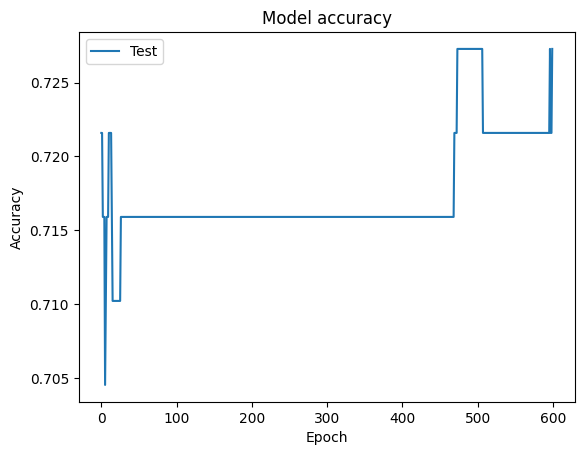

In [14]:

# Plot training & validation accuracy values
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test'], loc='upper left')
plt.show()